## Process data by joining everything together

In [12]:
import pandas as pd
from pyproj import Transformer
from scipy.spatial import distance
import numpy as np


In [ ]:
# join the four datasets together
NO2 = pd.read_csv("Data/AirQuality/NO2.csv")
PM10 = pd.read_csv("Data/AirQuality/PM10.csv")
PM25 = pd.read_csv("Data/AirQuality/PM25.csv")
SO2 = pd.read_csv("Data/AirQuality/SO2.csv")



In [83]:
# change the column names to be the same
NO2.columns = ['Measurement' if col == "NO2 (ug/m3)" else col for col in NO2.columns]
PM10.columns = ['Measurement' if col == "PM10 (ug/m3)" else col for col in PM10.columns]
PM25.columns = ['Measurement' if col == "PM25 (ug/m3)" else col for col in NO2.columns]
SO2.columns = ['Measurement' if col == "SO2 (ug/m3)" else col for col in NO2.columns]

In [103]:
NO2['SpeciesType'] = 'NO2'
PM10['SpeciesType'] = 'PM10'
PM25['SpeciesType'] = 'PM25'
SO2['SpeciesType'] = 'SO2'

In [104]:
AQ_combined = pd.concat([NO2, PM10, PM25, SO2])
AQ_combined.sample(5)

,MeasurementDateGMT,Measurement,SiteCode,LocalAuthorityCode,LocalAuthorityName,SiteName,SiteType,DateOpened,DateClosed,Latitude,Longitude,SpeciesType
39975,2018-01-30 21:00,130.7,CD9,6,Camden,Camden - Euston Road,Roadside,2011-01-29 00:00:00,2020-07-02 00:00:00,51.527975,-0.128774,NO2
144198,2018-02-20 12:00,27.9,NM2,25,Newham,Newham - Cam Road,Roadside,1998-08-18 00:00:00,NaN,51.537598,-0.002138,NO2
34050,2018-02-23 03:00,23.3,BX2,3,Bexley,Bexley - Belvedere,Suburban,1998-01-24 15:00:00,NaN,51.490610,0.158914,PM10
20194,2018-01-17 01:00,5.0,WA9,32,Wandsworth,Wandsworth - Putney,Urban Background,2011-01-04 00:00:00,NaN,51.465033,-0.215825,PM10
140061,2018-02-28 05:00,13.6,BQ8,3,Bexley,Bexley - Belvedere West FDMS,Urban Background,2010-08-24 00:00:00,2022-02-23 00:00:00,51.494649,0.137279,PM10


In [86]:
AQ_combined.to_csv("Data/AirQuality/AQ_combined.csv", index=False)

pair the sites

In [87]:
# read the congestion data for their coordinates
CS_coor = pd.read_csv("Data/CongestionScoot/Metadata(siteCoordinates.csv")
CS_coor.sample(5)

transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)

# transform the coordinates to lat and long
CS_coor['Longitude'], CS_coor['Latitude'] = zip(*CS_coor.apply(lambda x: transformer.transform(x['Easting'], x['Northing']), axis=1))

In [20]:
CS_coor.sample(5)

,ID,Easting,Northing,Longitude,Latitude
1111,05-296,535027,182214,-0.055095,51.522710
3936,30-123,528007,191500,-0.152845,51.607795
1250,06-183,539554,178911,0.008808,51.491930
1075,05-210,534803,182705,-0.058134,51.527176
3939,30-133,528273,191190,-0.149120,51.604949


In [88]:
# calculate the distance between the air quality monitoring stations and the congestion monitoring stations

dist_matrix = distance.cdist(AQ_combined[['Latitude', 'Longitude']], CS_coor[['Latitude', 'Longitude']], 'euclidean')

min_dist_indices = np.argmin(dist_matrix, axis=1)
# 
closest_ids = pd.Series(CS_coor['ID'].iloc[min_dist_indices].values)
# add the closest congestion monitoring station to the air quality monitoring station
AQ_combined['ID'] = closest_ids
# save the combined dataset
AQ_combined.to_csv("Data/AirQuality/AQ_combined.csv", index=False)

In [70]:
# read the combined dataset
AQ_combined = pd.read_csv("Data/AirQuality/AQ_combined.csv")

In [90]:
# get the unique congestion monitoring station ids
CS_ids = AQ_combined['ID'].unique()

CS_ids

array(['20-140', '07-268', '28-027', '20-261', '01-329', '10-037',
       '09-076', '20-139', '07-034', '14-004', '27-102', '06-266',
       '20-017', '08-177', '10-136', '00-042', '17-258', '01-083',
       '02-144', '18-064', '32-071', '18-103', '09-081', '19-092',
       '10-264', '26-151', '16-139', '27-271', '03-080', '21-024',
       '29-006', '06-016', '06-010', '10-070', '01-241', '09-253',
       '07-143', '31-027', '28-124', '15-006', '14-099', '01-103',
       '02-052', '15-114', '06-053', '10-254', '32-002', '02-045',
       '31-002', '32-083', '06-191', '06-299', '10-125', '21-020',
       '24-146', '04-125', '24-132', '02-122', '28-193', '05-107',
       '27-255', '01-379', '06-265', '23-057', '06-067', '32-205',
       '17-197', '03-112', '20-307', '22-033', '15-007', '05-098',
       '00-083', '29-035', '28-149', '00-028', '08-038', '06-066',
       '26-068', '06-033', '24-092', '12-065'], dtype=object)

In [91]:
CS_data_merged = pd.DataFrame()
# merge all the congestion data together based on the list of IDs

for CS_id in CS_ids:
    filename = f"{CS_id}.csv"
    CS_data = pd.read_csv(f"Data/CongestionScoot/MergedCSVs/{filename}")

    CS_data['ID'] = CS_id
    # merge the Date and Time columns into a single column


    # 将Date和Time列合并为一个字符串列
    CS_data['DateTimeStr'] = CS_data['Date'] + ' ' + CS_data['Time']

    # 将合并后的字符串转换为datetime格式，并创建一个新列
    CS_data['MeasurementDateGMT'] = pd.to_datetime(CS_data['DateTimeStr'], format='%d-%b-%Y %H:%M')

    # 如果你想要将datetime列的格式化输出为'yyyy-mm-dd HH:MM'样式，可以这样做
    # 注意：这一步实际上会将列转换回字符串格式，所以如果你需要保留datetime对象，可以跳过这一步
    CS_data['MeasurementDateGMT'] = CS_data['MeasurementDateGMT'].dt.strftime('%Y-%m-%d %H:%M')

    CS_data_merged = pd.concat([CS_data_merged, CS_data])
        


In [ ]:
# merge the air quality and congestion data together
AQ_CS_All = pd.merge(AQ_combined, CS_data_merged, left_on=['ID', 'MeasurementDateGMT'], right_on=['ID', 'MeasurementDateGMT'], how='left')
AQ_CS_All.to_csv("Data/AirQuality/AQ_CS_All.csv", index=False)

In [97]:
# read the weather data
Weather = pd.read_csv("Data/weather_cleaned.csv")

In [100]:
# merge the weather data with the air quality and congestion data

Weather['MeasurementDateGMT'] = Weather['date']
Weather.sample(15)

AQ_CS_All_all = pd.merge(AQ_CS_All, Weather, left_on=['MeasurementDateGMT'], right_on=['MeasurementDateGMT'], how='left')

In [102]:
# save the final dataset
AQ_CS_All_all.to_csv("Data/AQ_CS_All.csv", index=False)

## calculate the distance between the sites

In [108]:
CS_XY = pd.read_csv("Data/CongestionScoot/Metadata(siteCoordinates.csv")

CS_XY['Longitude'], CS_XY['Latitude'] = zip(*CS_XY.apply(lambda x: transformer.transform(x['Easting'], x['Northing']), axis=1))

QA_XY = pd.read_csv("Data/AirQuality/MonitoringSites.csv")

In [111]:
dist_matrix2 = distance.cdist(QA_XY[['Latitude', 'Longitude']], CS_XY[['Latitude', 'Longitude']], 'euclidean')

DF_dist_matrix2 = pd.DataFrame(dist_matrix2, index=QA_XY['SiteCode'], columns=CS_XY['ID'])

## calculate the correlation between the air quality and the congestion

#### after checking the map(html), the ID=02-064 and ID=02-144 are close to the air quality site SiteCode=CD9
#### so import those three datasets and analyze the correlation between the air quality and the congestion

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import os
import geopandas as gpd
from scipy.stats import pearsonr
import pykrige

import statsmodels.api as sm


from scipy.stats import spearmanr, kendalltau

                            OLS Regression Results                            
Dep. Variable:                HG1-NO2   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     259.3
Date:                Wed, 21 Feb 2024   Prob (F-statistic):           3.56e-55
Time:                        10:38:50   Log-Likelihood:                -9478.6
No. Observations:                2161   AIC:                         1.896e+04
Df Residuals:                    2159   BIC:                         1.897e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.2423      0.779     36.233      0.0

C:\Users\SBH\AppData\Local\Temp\ipykernel_26056\3463418889.py:62: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(cmap)


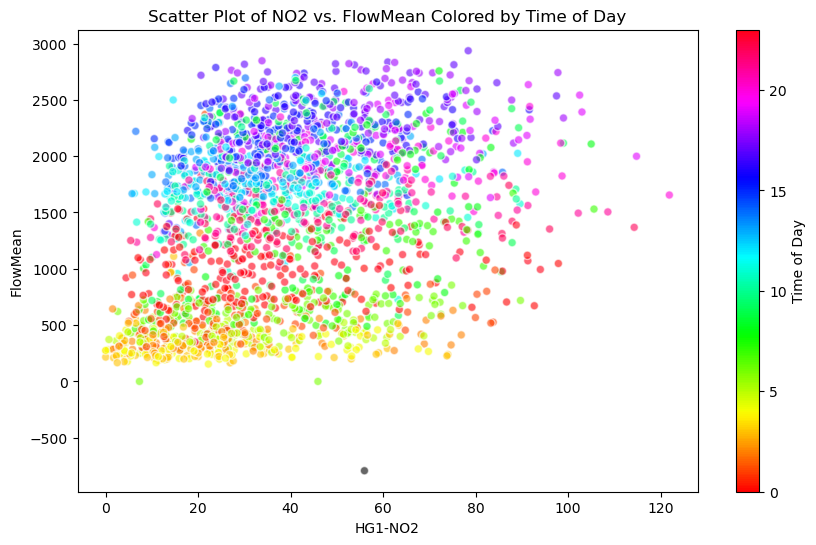

Spearman Corr: 0.3648515879809715, p-value: 5.010320585789782e-69
Kendall Tau: 0.2477612512878089, p-value: 1.1867573691873142e-66


In [4]:
AQ_code = "HG1"
Species_code = "NO2"
CS_code = "31-027"

url_AQ = f"Data/AirQuality/{Species_code}/{AQ_code}.csv"
url_CS = f"Data/CongestionScoot/MergedCSVs/{CS_code}.csv"

AQ_test = pd.read_csv(url_AQ)
CS_test = pd.read_csv(url_CS)

CS_test['DateTimeStr'] = CS_test['Date'] + ' ' + CS_test['Time']
CS_test['MeasurementDateGMT'] = pd.to_datetime(CS_test['DateTimeStr'], format='%d-%b-%Y %H:%M')
CS_test.drop(columns=['DateTimeStr'], inplace=True)
AQ_test['MeasurementDateGMT'] = pd.to_datetime(AQ_test['MeasurementDateGMT'])
CS_test['MeasurementDateGMT'] = pd.to_datetime(CS_test['MeasurementDateGMT'])
AQCS_Merged = pd.merge(AQ_test, CS_test, on='MeasurementDateGMT', how='left')

AQ_CS_test = AQCS_Merged.set_index('MeasurementDateGMT')

# 要替换的新列名
AQ_measure_colname = f"{AQ_code}-{Species_code}"

# 遍历列名，替换包含":"的列名
AQ_CS_test.columns = [AQ_measure_colname if ':' in col else col for col in AQ_CS_test.columns]

# 对特定列进行样条插值
AQ_CS_test[AQ_measure_colname] = AQ_CS_test[AQ_measure_colname].interpolate(method='spline', order=3)
AQ_CS_test[AQ_measure_colname] = AQ_CS_test[AQ_measure_colname].clip(lower=0)
AQ_CS_test['SatMean'] = AQ_CS_test['SatMean'].interpolate(method='spline', order=3)
AQ_CS_test['FlowMean'] = AQ_CS_test['FlowMean'].interpolate(method='spline', order=3)

X = AQ_CS_test['SatMean'] 
y = AQ_CS_test[AQ_measure_colname]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

# 打印模型的摘要
print(model.summary())

corr_coefficient, p_value = pearsonr(AQ_CS_test[AQ_measure_colname], AQ_CS_test['FlowMean'])
print(f'Pearson_Corr: {corr_coefficient}, p-value: {p_value}')

#----------------------scatter plot----------------------
AQ_CS_test['Hour'] = AQ_CS_test['Time'].str.split(':').str[0].astype(float)

norm = colors.Normalize(vmin=0, vmax=23)

# 接下来，创建一个颜色映射对象
cmap = cm.ScalarMappable(norm=norm, cmap='hsv')

plt.figure(figsize=(10, 6))
plt.scatter(x= AQ_measure_colname,
            y='FlowMean',
            c=cmap.to_rgba(AQ_CS_test['Hour']),  # 使用颜色映射对象为数据点着色
            data=AQ_CS_test,
            alpha=0.6,  
            edgecolors='w')  

# 添加色带
cbar = plt.colorbar(cmap)
cbar.set_label('Time of Day')

plt.xlabel(f'{AQ_measure_colname}')
plt.ylabel('FlowMean')
plt.title(f'Scatter Plot of {Species_code} vs. FlowMean Colored by Time of Day')
plt.show()


# calculate the Spearman correlation
spearman_corr, spearman_p_value = spearmanr(AQ_CS_test[AQ_measure_colname], 
                                             AQ_CS_test['FlowMean'])
print(f'Spearman Corr: {spearman_corr}, p-value: {spearman_p_value}')

# calculate the Kendall correlation
kendall_corr, kendall_p_value = kendalltau(AQ_CS_test[AQ_measure_colname], 
                                           AQ_CS_test['FlowMean'])
print(f'Kendall Tau: {kendall_corr}, p-value: {kendall_p_value}')

In [2]:
AQ_CD9 = pd.read_csv("Data/AirQuality/NO2/NB1.csv")
CS_02_064 = pd.read_csv("Data/CongestionScoot/MergedCSVs/01-330.csv")
CS_02_144 = pd.read_csv("Data/CongestionScoot/MergedCSVs/02-032.csv")

In [30]:
AQ_CD9.sample(4)

,MeasurementDateGMT,Camden - Swiss Cottage: PM2.5 Particulate (ug/m3)
1363,2018-02-11 19:00,3.8
691,2018-01-14 19:00,24.3
295,2017-12-29 07:00,10.1
878,2018-01-22 14:00,NaN


In [31]:
CS_02_064.sample(4)

,DateTime,Date,Time,SatMean,SatBand,FlowMean
5855,43146.958333,15-Feb-2018,23:00,43.0,0-79%,1202
3024,43117.500000,17-Jan-2018,12:00,63.0,0-79%,1883
4217,43129.927083,29-Jan-2018,22:15,27.0,0-79%,1072
4521,43133.093750,2-Feb-2018,02:15,0.0,0-79%,536


In [32]:
CS_02_144.sample(4)

,DateTime,Date,Time,SatMean,SatBand,FlowMean
1608,43102.750000,2-Jan-2018,18:00,61.75,0-79%,4436
4902,43137.062500,6-Feb-2018,01:30,14.50,0-79%,745
3432,43121.750000,21-Jan-2018,18:00,71.00,0-79%,4920
7330,43162.322917,3-Mar-2018,07:45,45.00,0-79%,2177


***Processing three datasets by merging them together***

In [3]:
# merge the Date and Time columns into a single column
# 将Date和Time列合并为一个字符串列
CS_02_064['DateTimeStr'] = CS_02_064['Date'] + ' ' + CS_02_064['Time']

# convert the merged string to datetime format and create a new column
# 将合并后的字符串转换为datetime格式，并创建一个新列
CS_02_064['MeasurementDateGMT'] = pd.to_datetime(CS_02_064['DateTimeStr'], format='%d-%b-%Y %H:%M')

# drop the middle DateTimeStr column
# 删除中间的DateTimeStr列
CS_02_064.drop(columns=['DateTimeStr'], inplace=True)

# make sure the new column is in datetime format
AQ_CD9['MeasurementDateGMT'] = pd.to_datetime(AQ_CD9['MeasurementDateGMT'])
CS_02_064['MeasurementDateGMT'] = pd.to_datetime(CS_02_064['MeasurementDateGMT'])

# merge the two dataframes
Merged = pd.merge(AQ_CD9, CS_02_064, on='MeasurementDateGMT', how='left')

In [4]:
# adopt some method to interpolate the missing values

Corrtest = Merged.set_index('MeasurementDateGMT')



# 对特定列进行样条插值
Corrtest['Westminster - Strand (Northbank BID): Nitrogen Dioxide (ug/m3)'] = Corrtest['Westminster - Strand (Northbank BID): Nitrogen Dioxide (ug/m3)'].interpolate(method='spline', order=3)
Corrtest['Westminster - Strand (Northbank BID): Nitrogen Dioxide (ug/m3)'] = Corrtest['Westminster - Strand (Northbank BID): Nitrogen Dioxide (ug/m3)'].clip(lower=0)
Corrtest['SatMean'] = Corrtest['SatMean'].interpolate(method='spline', order=3)
Corrtest['FlowMean'] = Corrtest['FlowMean'].interpolate(method='spline', order=3)

In [5]:
# check the merged dataframe
Corrtest.head(14)

,Westminster - Strand (Northbank BID): Nitrogen Dioxide (ug/m3),DateTime,Date,Time,SatMean,SatBand,FlowMean
MeasurementDateGMT,,,,,,,
2017-12-17 00:00:00,71.8,43086.000000,17-Dec-2017,00:00,21.0,0-79%,764.0
2017-12-17 01:00:00,84.9,43086.041667,17-Dec-2017,01:00,19.0,0-79%,617.0
2017-12-17 02:00:00,82.1,43086.083333,17-Dec-2017,02:00,0.0,0-79%,404.0
2017-12-17 03:00:00,67.0,43086.125000,17-Dec-2017,03:00,0.0,0-79%,496.0
2017-12-17 04:00:00,64.9,43086.166667,17-Dec-2017,04:00,0.0,0-79%,381.0
2017-12-17 05:00:00,54.9,43086.208333,17-Dec-2017,05:00,0.0,0-79%,349.0
2017-12-17 06:00:00,52.1,43086.250000,17-Dec-2017,06:00,0.0,0-79%,286.0
2017-12-17 07:00:00,73.9,43086.291667,17-Dec-2017,07:00,0.0,0-79%,315.0
2017-12-17 08:00:00,80.0,43086.333333,17-Dec-2017,08:00,0.0,0-79%,463.0


In [32]:
# 准备数据
X = Corrtest[['SatMean', 'FlowMean']]  # 自变量
y = Corrtest['Westminster - Strand (Northbank BID): Nitrogen Dioxide (ug/m3)']  # 因变量

# 添加常数项以拟合截距
X = sm.add_constant(X)

# 拟合多元线性回归模型
model = sm.OLS(y, X).fit()

# 打印模型的摘要
print(model.summary())

                                                  OLS Regression Results                                                  
Dep. Variable:     Westminster - Strand (Northbank BID): Nitrogen Dioxide (ug/m3)   R-squared:                       0.418
Model:                                                                        OLS   Adj. R-squared:                  0.418
Method:                                                             Least Squares   F-statistic:                     775.2
Date:                                                            Wed, 21 Feb 2024   Prob (F-statistic):          1.94e-254
Time:                                                                    02:28:01   Log-Likelihood:                -10055.
No. Observations:                                                            2161   AIC:                         2.012e+04
Df Residuals:                                                                2158   BIC:                         2.013e+04
Df Model:       

In [34]:
corr_coefficient, p_value = pearsonr(Corrtest['Westminster - Strand (Northbank BID): Nitrogen Dioxide (ug/m3)'], Corrtest['FlowMean'])
print(f'Pearson_Corr: {corr_coefficient}, p-value: {p_value}')

Pearson_Corr: 0.6327270229759792, p-value: 4.775906203765245e-242


In [35]:
Corrtest['Hour'] = Corrtest['Time'].str.split(':').str[0].astype(float)

C:\Users\SBH\AppData\Local\Temp\ipykernel_42684\2554867403.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(cmap)


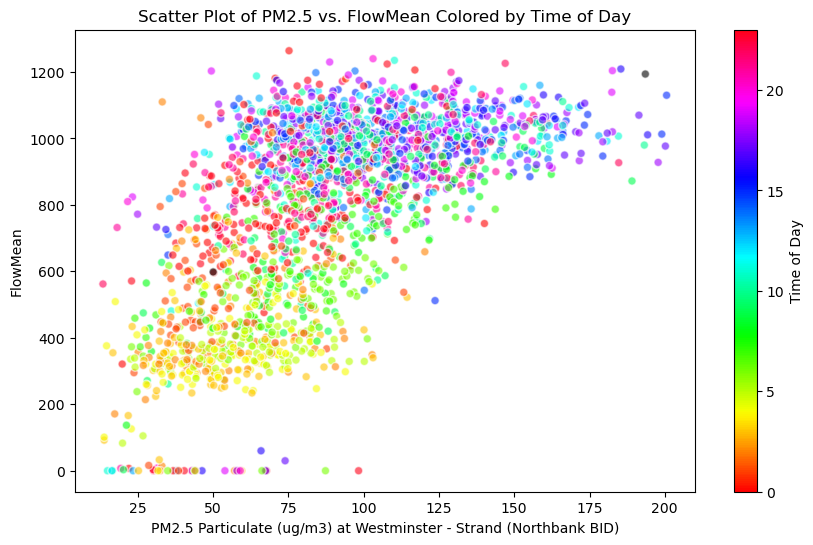

In [41]:
norm = colors.Normalize(vmin=Corrtest['Hour'].min(), vmax=Corrtest['Hour'].max())

# 接下来，创建一个颜色映射对象
cmap = cm.ScalarMappable(norm=norm, cmap='hsv')

plt.figure(figsize=(10, 6))
plt.scatter(x='Westminster - Strand (Northbank BID): Nitrogen Dioxide (ug/m3)',
            y='FlowMean',
            c=cmap.to_rgba(Corrtest['Hour']),  # 使用颜色映射对象为数据点着色
            data=Corrtest,
            alpha=0.6,  
            edgecolors='w')  

# 添加色带
cbar = plt.colorbar(cmap)
cbar.set_label('Time of Day')

plt.xlabel('PM2.5 Particulate (ug/m3) at Westminster - Strand (Northbank BID)')
plt.ylabel('FlowMean')
plt.title('Scatter Plot of PM2.5 vs. FlowMean Colored by Time of Day')
plt.show()

In [43]:

# calculate the Spearman correlation
spearman_corr, spearman_p_value = spearmanr(Corrtest['Westminster - Strand (Northbank BID): Nitrogen Dioxide (ug/m3)'], 
                                             Corrtest['FlowMean'])
print(f'Spearman Corr: {spearman_corr}, p-value: {spearman_p_value}')

# calculate the Kendall correlation
kendall_corr, kendall_p_value = kendalltau(Corrtest['Westminster - Strand (Northbank BID): Nitrogen Dioxide (ug/m3)'], 
                                           Corrtest['FlowMean'])
print(f'Kendall Tau: {kendall_corr}, p-value: {kendall_p_value}')

Spearman Corr: 0.6247897393710217, p-value: 2.653409657999718e-234
Kendall Tau: 0.4417884619465107, p-value: 1.4475330049262784e-207
